In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
csvSample = './data/health/Mpu_Data_2019_01_10_15_31_53.csv'

In [3]:
#df = pd.read_csv(csvSample)

In [4]:
import scipy.signal as signal
import pywt
import pylab as pl


In [5]:
import csv
import os
from math import sqrt
import numpy as np
import scipy.signal as signal
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pylab as pl
import pywt
#,'ZCN[1]','ZCN[2]'
column_name1=['range[0]','max[1]','mean[1]','mean_abs[1]','RMS[1]','STD[1]','skew[1]',
              'ZCN[1]','CoV[1]']
column_name2=['range[1]','max[2]','mean[2]','mean_abs[2]','RMS[2]','STD[2]','skew[2]',
              'ZCN[2]','CoV[2]']


In [6]:
healthPath = 'D:\workspace\BIT\PA\data\health'

In [7]:
a = glob.glob(os.path.join(healthPath,"*"))
a

['D:\\workspace\\BIT\\PA\\data\\health\\Mpu_Data_2019_01_10_15_31_53.csv',
 'D:\\workspace\\BIT\\PA\\data\\health\\Mpu_Data_2019_01_10_15_35_37.csv',
 'D:\\workspace\\BIT\\PA\\data\\health\\Mpu_Data_2019_01_10_15_41_07.csv',
 'D:\\workspace\\BIT\\PA\\data\\health\\Mpu_Data_2019_01_10_16_05_00.csv',
 'D:\\workspace\\BIT\\PA\\data\\health\\Mpu_Data_2019_01_11_20_53_50.csv',
 'D:\\workspace\\BIT\\PA\\data\\health\\Mpu_Data_2019_01_12_20_10_18.csv',
 'D:\\workspace\\BIT\\PA\\data\\health\\Mpu_Data_2019_01_16_14_47_26.csv',
 'D:\\workspace\\BIT\\PA\\data\\health\\Mpu_Data_2019_01_16_14_56_54.csv',
 'D:\\workspace\\BIT\\PA\\data\\health\\Mpu_Data_2019_01_16_15_02_54.csv']

In [8]:
def load_data(path):
    #os.chdir(path)
    #files=os.listdir(path)
    data=[]
    for file in glob.glob(os.path.join(path,"*.csv")): #遍历文件夹
        print('File []', file)
        meta_data=pd.read_csv(file,skiprows=range(0, 2))
        data.append(meta_data) #每个文件的文本存到list中
    #data=[create_data(file) for file in glob.glob("*.csv")]
    return data

def band_filter(data):
        b,a=signal.butter(8,[0.005,0.6],'bandpass')
        buffer_data=signal.filtfilt(b,a,data)
        return buffer_data
    
def wavelet_dec(data):
        db4=pywt.Wavelet('db4')
        A5,D5,D4,D3,D2,D1= pywt.wavedec(data,db4,mode='symmetric',level=5)
        D5=np.zeros(D5.shape[0])
        D4=np.zeros(D4.shape[0])
        D3=np.zeros(D3.shape[0])
        D2=np.zeros(D2.shape[0])
        D1=np.zeros(D1.shape[0])
        data_rec=pywt.waverec([A5,D5,D4,D3,D2,D1],db4)
        return data_rec
    
def data_pre(data):
    b=[]
    meta=['Acce_0','Gyro_0','Acce_1','Gyro_1','Acce_2','Gyro_2']
    for i in data:
        a=pd.DataFrame(columns=meta)
        for j in meta:   
            a[j]=wavelet_dec(i[j])
        b.append(a)
    return b

def merge_data(i,item1,item2,item3):
    merge=i[item1]**2+ i[item2]**2+ i[item3]**2
    return np.sqrt(merge)

def data_merged(raw_data):
    data=[]   
    #for i in data_pre(raw_data):
    for i in raw_data:
        a=pd.DataFrame(columns=['Acce_0','Gyro_0','Acce_1','Gyro_1','Acce_2','Gyro_2'])
        Acce_0=merge_data(i,meta[0],meta[1],meta[2])
        Gyro_0=merge_data(i,meta[3],meta[4],meta[5])
        Acce_1=merge_data(i,meta[6],meta[7],meta[8])
        Gyro_1=merge_data(i,meta[9],meta[10],meta[11])
        Acce_2=merge_data(i,meta[12],meta[13],meta[14])
        Gyro_2=merge_data(i,meta[15],meta[16],meta[17])
        a['Acce_0']=Acce_0
        a['Acce_1']=Acce_1
        a['Acce_2']=Acce_2
        a['Gyro_0']=Gyro_0
        a['Gyro_1']=Gyro_1
        a['Gyro_2']=Gyro_2
        data.append(a)
    #data=data_pre(data)
    return data

def ext_fea(item):
    return [np.ptp(item),np.max(item),np.mean(item),np.mean(abs(item)),
            mse(item),np.std(item),item.skew(),calZeroCrossingNum(item),
            np.std(item)/np.mean(item)]

def segment(data,column):
    data=data[column]-data[column][0:100].mean()
    data_mid=signal.medfilt(abs(data),251)
    start=[]
    end=[]
    low=1
    high=0
    for i in range(len(data_mid)):
        if low==1:
            if data_mid[i]>0.6:
                start.append(i)
                low=0
                high=1
                continue
        if high==1:
            if data_mid[i]<0.4:
                end.append(i)
                high=0
                low=1
                continue

    drop_i=[]
    for i in range(len(start)):
        #print(i)
        if end[i]-start[i]<500:
            drop_i.append(i)
    
    for i in drop_i:
        start[i]=0
        end[i]=0
    #start.remove(0)
    #end.drop(0)
    for i in range(len(drop_i)):
        start.remove(0)
        end.remove(0)
    start=[i-120 for i in start]
    end=[i+100 for i in end]
    return start,end

In [9]:
def seg_fea(start,end,data,fea):
    feature=pd.DataFrame(columns=column_name1)
    data=data[fea]-data[fea][0:100].mean()
    for i in range(len(start)):
        feature.loc[i]=(ext_fea(data[start[i]:end[i]]))
    return [feature[col].mean() for col in feature.columns]

#def ext_fea(item,feature):
#    return [np.max(item[feature]),np.mean(item[feature]),mse(item[feature]),
#            np.std(item[feature])**2,np.std(item[feature])]
#    
def make_dataset(data):
    feature1=pd.DataFrame(columns=column_name1)
    feature2=pd.DataFrame(columns=column_name2)   
    for i,item in enumerate(data):
        start,end=segment(item,'Acce_1')
        feature1.loc[i]=seg_fea(start,end,item,'Acce_1')   
        #print(i)
        feature2.loc[i]=seg_fea(start,end,item,'Gyro_1')
    feature=pd.concat([feature1,feature2],axis=1)
    return feature

def mse(data):
    SUM=0
    for i in data:
        SUM=SUM+i*i
    return sqrt(SUM/len(data))


def neg_label(num):
    a=np.ones(num)
    for i in range(num):
        a[i]=-1
    return a

def pos_label(num):
    a=np.ones(num)
    for i in range(num):
        a[i]=1
    return a
  
def data_made(path):
    data_meta=load_data(path)
    data_filt=data_merged(data_meta)
    data=data_pre(data_filt)
    return data_meta,data_filt,data,make_dataset(data)

def calZeroCrossingNum(data) :
    data=data.reset_index(drop=True)
    SUM = 0
    for i in range(len(data)-1) :
        SUM = SUM + np.abs(sgn(data[i+1]) - sgn(data[i]))
    return SUM

def sgn(data):
    if data >= 0 :
        return 1
    else :
        return 0 

In [10]:
#print(os.getcwd()) # 打印当前工作目录    
#导入病人数据
meta=['Acce_x[0]','Acce_y[0]','Acce_z[0]','Gyro_x[0]','Gyro_y[0]','Gyro_z[0]',
      'Acce_x[1]','Acce_y[1]','Acce_z[1]','Gyro_x[1]','Gyro_y[1]','Gyro_z[1]',
      'Acce_x[2]','Acce_y[2]','Acce_z[2]','Gyro_x[2]','Gyro_y[2]','Gyro_z[2]']

healthPath = 'D:\workspace\BIT\PA\data\health'
PDdata_meta,PDdata_filt,PDdata,PDfeature=data_made(healthPath)

File [] D:\workspace\BIT\PA\data\health\Mpu_Data_2019_01_10_15_31_53.csv
File [] D:\workspace\BIT\PA\data\health\Mpu_Data_2019_01_10_15_35_37.csv
File [] D:\workspace\BIT\PA\data\health\Mpu_Data_2019_01_10_15_41_07.csv
File [] D:\workspace\BIT\PA\data\health\Mpu_Data_2019_01_10_16_05_00.csv
File [] D:\workspace\BIT\PA\data\health\Mpu_Data_2019_01_11_20_53_50.csv
File [] D:\workspace\BIT\PA\data\health\Mpu_Data_2019_01_12_20_10_18.csv
File [] D:\workspace\BIT\PA\data\health\Mpu_Data_2019_01_16_14_47_26.csv
File [] D:\workspace\BIT\PA\data\health\Mpu_Data_2019_01_16_14_56_54.csv
File [] D:\workspace\BIT\PA\data\health\Mpu_Data_2019_01_16_15_02_54.csv


In [11]:
PDdata_meta

[       TimeStamp[0]  Acce_x[0]  Acce_y[0]  Acce_z[0]  Gyro_x[0]  Gyro_y[0]  \
 0             13542    -9.5134     3.6181    -0.0313    -0.0149    -0.0032   
 1             13543    -9.5061     3.6229    -0.0385    -0.0138    -0.0032   
 2             13544    -9.4965     3.6253    -0.0265    -0.0096    -0.0032   
 3             13545    -9.5134     3.6253    -0.0217    -0.0053    -0.0043   
 4             13546    -9.5254     3.6325    -0.0217    -0.0021    -0.0053   
 5             13547    -9.5326     3.6301    -0.0217     0.0021    -0.0075   
 6             13548    -9.5182     3.6349    -0.0241     0.0032    -0.0085   
 7             13549    -9.5206     3.6421    -0.0241     0.0085    -0.0085   
 8             13550    -9.5326     3.6662    -0.0385     0.0096    -0.0107   
 9             13551    -9.5254     3.6758    -0.0313     0.0117    -0.0107   
 10            13552    -9.5278     3.6806    -0.0313     0.0128    -0.0128   
 11            13553    -9.5278     3.6806    -0.031

In [12]:
PDdata

[          Acce_0    Gyro_0     Acce_1    Gyro_1    Acce_2    Gyro_2
 0      10.208685  0.027052  10.057930  0.011724  9.699216  0.002103
 1      10.211797  0.027557  10.057742  0.011435  9.699039  0.002061
 2      10.214953  0.028069  10.057553  0.011143  9.698859  0.002018
 3      10.218142  0.028586  10.057363  0.010848  9.698678  0.001974
 4      10.221504  0.029131  10.057162  0.010536  9.698487  0.001929
 5      10.225001  0.029699  10.056952  0.010212  9.698288  0.001881
 6      10.227954  0.030155  10.056728  0.009922  9.698115  0.001848
 7      10.230310  0.030488  10.056488  0.009669  9.697971  0.001831
 8      10.232361  0.030756  10.056236  0.009434  9.697841  0.001824
 9      10.233914  0.030922  10.055970  0.009230  9.697735  0.001830
 10     10.235393  0.031068  10.055692  0.009027  9.697632  0.001840
 11     10.236811  0.031196  10.055401  0.008824  9.697530  0.001853
 12     10.237781  0.031231  10.055095  0.008647  9.697449  0.001878
 13     10.238383  0.031188  10.05

In [13]:
len(PDdata)

9

In [14]:
PDdata[0].head()

,Acce_0,Gyro_0,Acce_1,Gyro_1,Acce_2,Gyro_2
0,10.208685,0.027052,10.057930,0.011724,9.699216,0.002103
1,10.211797,0.027557,10.057742,0.011435,9.699039,0.002061
2,10.214953,0.028069,10.057553,0.011143,9.698859,0.002018
3,10.218142,0.028586,10.057363,0.010848,9.698678,0.001974
4,10.221504,0.029131,10.057162,0.010536,9.698487,0.001929


In [16]:
x_len = int(f1.shape[0])

In [17]:
f1[10]

10.23539260614171

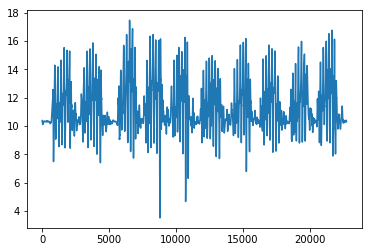

In [34]:
f1 = PDdata[2]['Acce_0']
plt.plot(f1)
#plt.imshow()

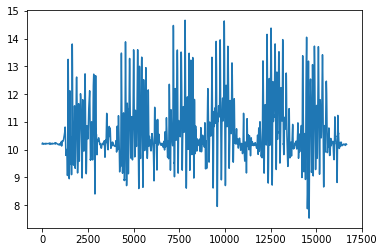

In [33]:
f1 = PDdata[0]['Acce_0']
plt.plot(f1)
#plt.imshow()

In [19]:
#print(os.getcwd()) # 打印当前工作目录    
#导入病人数据
meta=['Acce_x[0]','Acce_y[0]','Acce_z[0]','Gyro_x[0]','Gyro_y[0]','Gyro_z[0]',
      'Acce_x[1]','Acce_y[1]','Acce_z[1]','Gyro_x[1]','Gyro_y[1]','Gyro_z[1]',
      'Acce_x[2]','Acce_y[2]','Acce_z[2]','Gyro_x[2]','Gyro_y[2]','Gyro_z[2]']

paPath = 'D:\workspace\BIT\PA\data\PA'
PDdata_meta2,PDdata_filt2,PDdata2,PDfeature2=data_made(paPath)

File [] D:\workspace\BIT\PA\data\PA\Mpu_Data_2019_01_15_13_59_14.csv
File [] D:\workspace\BIT\PA\data\PA\Mpu_Data_2019_01_15_14_14_21.csv
File [] D:\workspace\BIT\PA\data\PA\Mpu_Data_2019_01_15_14_25_40.csv
File [] D:\workspace\BIT\PA\data\PA\Mpu_Data_2019_01_15_14_54_15.csv
File [] D:\workspace\BIT\PA\data\PA\Mpu_Data_2019_01_15_15_08_02.csv
File [] D:\workspace\BIT\PA\data\PA\Mpu_Data_2019_01_15_15_27_16.csv
File [] D:\workspace\BIT\PA\data\PA\Mpu_Data_2019_01_15_15_35_41.csv
File [] D:\workspace\BIT\PA\data\PA\Mpu_Data_2019_01_15_16_14_28.csv
File [] D:\workspace\BIT\PA\data\PA\Mpu_Data_2019_01_15_16_25_13.csv


In [47]:
f1_pa = PDdata2[4]['Acce_0']
f1_arr = np.asarray(f1_pa)
f1_arr.shape
f1_arr.mean()

10.6943669720735

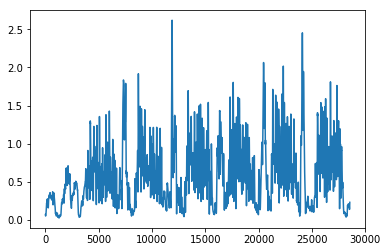

In [24]:
g1_pa = PDdata2[1]['Gyro_0']
x_len = int(g1_pa.shape[0])
plt.plot(g1_pa)

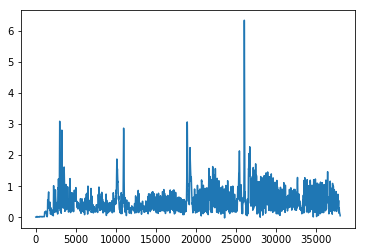

In [26]:
g1_pa = PDdata2[6]['Gyro_0']
x_len = int(g1_pa.shape[0])
plt.plot(g1_pa)

0.11842954745554504
0.11543406957698257
0.11239517473023541
0.10932329060540501
0.10608439421563438
0.10271500646152419
0.10007667555288739
0.09824176567343562
0.09683235815844304
0.0960943720401027
0.09550080178225011
0.09503489125196406
0.09518380661370478
0.09585149919721501
0.09646684888110177
0.0970522837230225
0.09783050558814436
0.0986724770638984
0.10006052398842862
0.10203425058454554
0.10425655540618643
0.1068447979182719
0.10916162480711347
0.11111555179699173
0.11309835540993021
0.11492465616939854
0.1168944075208558
0.11903853335870546
0.12104338830612767
0.12297000538406329
0.12541573665987213
0.12839024874283872
0.1316456663820191
0.13533249401654343
0.13902138722678758
0.14268484789545374
0.1466621520949978
0.15085892995641106
0.1541383459979929
0.15642354370799258
0.15818078384425238
0.15909073448281805
0.15988848172256626
0.16059492405381964
0.16055350132865664
0.15990022735434245
0.15933047805640854
0.15881004430145604
0.15808070337662725
0.1572978387530304
0.1558560

0.11645958913317239
0.11658252833564485
0.11703484232393917
0.11783760364590462
0.11870048168978482
0.1197719271109932
0.12066265394861195
0.1213367219712787
0.12210851277020428
0.12288743058921936
0.12362928768797973
0.12436447081001102
0.125047765790965
0.12567527675323617
0.1263424847432933
0.12704570039443316
0.1277351838218505
0.1284303367607477
0.12903040640448865
0.12952195410663872
0.1299665195347252
0.13033538015304705
0.1306715165501796
0.13097962955936426
0.1312130114895761
0.13138028062404822
0.1315071259045826
0.1315882105577994
0.13161567410026775
0.13159327194117665
0.1314930936544962
0.13131195600392762
0.1310650851809766
0.13074457023895336
0.13035120783090023
0.12988469618613854
0.12933718634738334
0.12870755804445697
0.12799610008152343
0.1271999858966345
0.12631664483883784
0.1253442297707508
0.12427638333690501
0.12311054598694267
0.12184669406650542
0.12048149564135192
0.11901473620784817
0.11744436899466278
0.11576621379475234
0.11397845950393913
0.11208056962893

2.66865914892834
2.644958067849569
2.613047628202127
2.5723658000796163
2.527550775485031
2.4769962065210054
2.4284749502842358
2.383147176775243
2.336094574325556
2.289580801322262
2.2400419964079274
2.1870749885996963
2.134452663044493
2.081437053025559
2.0204853674600263
1.9514409655719493
1.8774423601665928
1.7965717903085272
1.7141762953296227
1.6305863779171346
1.5415276966141405
1.448161669940491
1.3696481003684569
1.3074367741372679
1.2533581788711072
1.2128305363847935
1.1738016428220954
1.1358943561529915
1.1100433043348314
1.0940246662986386
1.0755816087953554
1.0552365883107213
1.0376477784399658
1.0200494026019546
1.0129118419394676
1.0170671622199108
1.0252197706906536
1.0399054567715424
1.0464921331061665
1.0429100851856785
1.0380206845520832
1.027564519971759
1.0184947276924485
1.0114902156538546
0.9993021693766473
0.9833277196422981
0.9770430972176142
0.9806284910166942
0.9884871235764464
1.0039932016956874
1.0173827952461896
1.0280123847157348
1.0435405760120235
1.061

0.515475951805188
0.44198128251326174
0.3933808288679947
0.3511173228154228
0.3144369784316772
0.30145683437257986
0.3088473761383332
0.31186003022727454
0.3110998778947387
0.31674115483412507
0.3230752483485285
0.35008159850262965
0.3994450110209266
0.45686001354108907
0.5271613629798276
0.5885651082205394
0.6376478642424286
0.6884100748512968
0.7344472293270173
0.7854085558027047
0.8424075047311766
0.8949579842345494
0.9450299550061226
1.0142364044162662
1.1030329241140882
1.2022993874527146
1.3175150351110436
1.4334030303524288
1.548976511799226
1.6764276304905954
1.812411799166605
1.9236406306794003
2.0081575466532473
2.0792356986015883
2.1276263291776973
2.1754412333498885
2.223317780975145
2.25187400087933
2.265260511794727
2.2830382463232977
2.3041759879057118
2.3216610307520456
2.3398657857321155
2.3415518939172197
2.3254225643987536
2.303342887859712
2.2711562661236204
2.2558219033679543
2.261015404485343
2.2708204688089557
2.2930723266940714
2.3146739340822573
2.3344466915097

1.2853700947243063
1.3275865682532602
1.3703895933467574
1.4219295398585463
1.4828832668083876
1.5494451574283843
1.6239007988672525
1.70139749847465
1.7817020711852265
1.8692807184027658
1.9632029741609298
2.058123931820082
2.1542058512596616
2.253469582174432
2.354672369538508
2.4622227214159453
2.576440416020204
2.6941620502668164
2.8164248480399228
2.920344895763435
3.0032849116648137
3.0767390542441326
3.134009692381408
3.1875170859738695
3.2378252933762317
3.2726138447744346
3.2941149924424535
3.319950959681411
3.349775909414174
3.376273841507252
3.4035443333588504
3.4175647489501633
3.4171600726353333
3.4124667814112777
3.4001100177975356
3.3942835287708566
3.3973151227929224
3.39992643873025
3.4063195110583733
3.4104046400995593
3.411453877456009
3.4162367301492913
3.4235185200885634
3.418905563627307
3.402079074733471
3.37917340851314
3.346540556627027
3.3143073592781627
3.283143074420375
3.2449568786562693
3.2019728256052264
3.164672670904916
3.133163173412957
3.1040699605467

2.8638573255850117
2.8310321125925944
2.8062916295279265
2.7802358798355002
2.7570684685820606
2.7308275351956803
2.700767444714395
2.6735924399551094
2.6480869990697444
2.609615825087557
2.5578270522360307
2.4989773386229484
2.429345450037777
2.3591658590935123
2.2891099524946408
2.2109641020122357
2.1269677827134923
2.060018431537839
2.011475189481303
1.972161314292012
1.9484385313121564
1.9251381921095936
1.9018135507447935
1.8917732345107252
1.892166589023967
1.889494231094657
1.8844564799510946
1.8818979112797274
1.8787957139319524
1.887019266824986
1.9074585527327397
1.9319304374071709
1.9632933109240873
1.9831764472613014
1.989062797904077
1.9918151984368304
1.9860903932456295
1.980786942164853
1.9767071507665024
1.9646545995134759
1.9463926194455292
1.9383457290644655
1.9406653595429615
1.9465438280654843
1.9600588337604772
1.9691653224916787
1.9730449332302704
1.981049163185391
1.990479938549255
1.9917947946079515
1.985060362832124
1.9728206814272857
1.9525725944537662
1.93202

2.116383983672263
2.2486220505021532
2.388549392419296
2.535719277108964
2.6565169229992174
2.7478243393549238
2.8251247526522394
2.878776171203121
2.9286611755208463
2.9755304258821877
3.000688824462573
3.0077783958299427
3.020253003305398
3.0373901085124526
3.0498951848452975
3.0631513095548026
3.057817617546668
3.0323309314468707
3.0004286624638437
2.957451246925165
2.9269136711648773
2.912363536732492
2.8991340263557763
2.8941259265677868
2.8866149614349794
2.875478706021816
2.8722012048410406
2.87463112422062
2.8602728001834894
2.828756090721167
2.7895453345407595
2.736989314188908
2.687212425032736
2.641291248109766
2.586505700409796
2.5264272272487847
2.4781736405547132
2.442022359897776
2.412459676424472
2.3940461407315405
2.3738588945240813
2.351633669031283
2.3378879849463226
2.330135586554467
2.3206771487444326
2.310242659342859
2.301023423025382
2.2913854887327525
2.288953194558385
2.2942281851758564
2.3022279750941372
2.3147910741878857
2.3157726238155045
2.303183687938733

1.700119277077558
1.6589012318119165
1.615632263402834
1.5703400722983516
1.5229973409082511
1.4731921520398785
1.4208721594326612
1.366193930330075
1.3090268292659972
1.2495752617243154
1.1878273077921073
1.1235506865216345
1.0567660651899444
0.9987530976593502
0.9506188448797194
0.907079903214123
0.8713913867405723
0.8370008117635375
0.8036579065608535
0.7776016551017754
0.7576417282238309
0.7357176591856301
0.7120608795879535
0.6899109260701567
0.667415628082953
0.6511754453647891
0.6417335177255022
0.6343911349472336
0.6307422053004318
0.6229821980487297
0.6099227296933575
0.596470706592947
0.5803357411692539
0.5650550407302464
0.5510092884803794
0.5344007091090399
0.5159431695481567
0.5031781457383027
0.49624037619279837
0.49195678899642403
0.4922276184819534
0.4916693820504768
0.4899271203824783
0.49126328096383615
0.4944902354446575
0.5041698763384997
0.5212747143204036
0.5428505834209397
0.5703741157422817
0.6022923684340711
0.6385030632618449
0.68118256500465
0.730128516597174

2.357012669375517
2.363030009202327
2.3545353656414356
2.3414918371372804
2.3204455647146176
2.312587128408918
2.3208745904598427
2.33266023998804
2.3541193787443655
2.375097752483316
2.3946575574119433
2.4233625815396405
2.459198716270382
2.4829876227919625
2.4945290242652507
2.5017984845796084
2.500026027295188
2.50322112509488
2.5123351296509764
2.516463925933338
2.5187412605234796
2.5220069620301913
2.525323207972956
2.5295823689057046
2.5352828199531743
2.5381707331808467
2.5382998756428634
2.538176757233304
2.5369187669067053
2.536455387994918
2.537187982350204
2.537570375194632
2.5381734005209378
2.5385934773437424
2.538699026548459
2.539187424393379
2.5399683678781284
2.535146714852623
2.52425389237661
2.5100156670026106
2.490786234054194
2.4701148025514894
2.4481717060478903
2.4217167406426925
2.391434215761045
2.3611246676509494
2.3306677706752525
2.298644252165976
2.2659378221196103
2.2293995633623704
2.188805386993673
2.1464128993424056
2.101483311986974
2.060319132585161
2

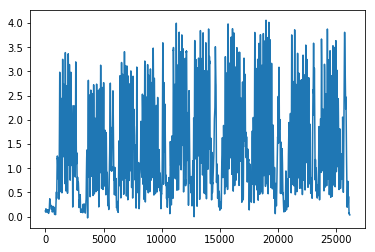

In [42]:
g1 = PDdata[1]['Gyro_0']
plt.plot(g1)
for i in g1:
    print(i)

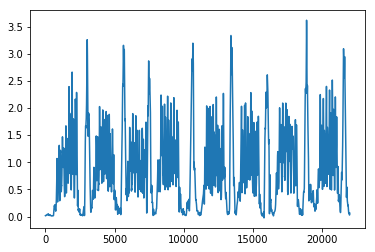

In [27]:
g1 = PDdata[3]['Gyro_0']
plt.plot(g1)

In [57]:
def split(arr, start_step=0, fix_step=600):
    arr_crop = []
    len_arr = len(arr)
    crop_len = len_arr - start_step
    crop_num = crop_len//fix_step
    
    for i in range(crop_num):
        crop_i = arr[(start_step+fix_step*i):(start_step+fix_step*(i+1))]
        arr_crop.append(crop_i)
        
    return arr_crop

#f1_pa = PDdata2[4]['Acce_0']
#f1_arr = np.asarray(f1_pa)

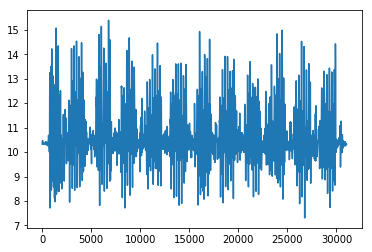

In [113]:
f1_pa = PDdata[8]['Acce_0']
f1_arr = np.asarray(f1_pa)
plt.plot(f1_pa)


In [110]:
#all_col = []

In [114]:
col = split(f1_arr, 1000)
for i in col:
    all_col.append(i)

In [115]:
len(all_col)

331

In [116]:
import numpy as np
np.save('health.npy', all_col)

In [118]:
len(all_col)

331

In [120]:
col_pa = np.load('pd.npy')

In [121]:
len(col_pa)

343